In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat
import scipy.optimize as opt
#fmin_cg to train linear reg

In [2]:
df = loadmat("ex5data1.mat")

In [3]:
# Training set
X = df['X']
y = df['y']
# Cross Validation Set
Xtest = df['Xtest']
ytest = df['ytest']
# Test Set
Xval = df['Xval']
yval = df['yval']

Text(0, 0.5, 'Water flowing out of the dam(y)')

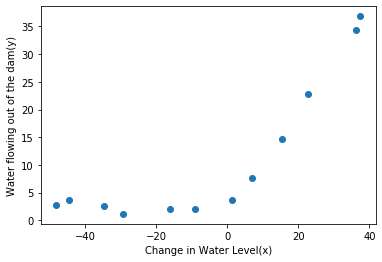

In [4]:
# Plot training data
m = X.shape[0]
plt.scatter(X,y)
plt.xlabel("Change in Water Level(x)")
plt.ylabel("Water flowing out of the dam(y)")

In [5]:
# Cost Function
def LinearRegCostFunction(theta,X, y,lmbda):
    m = len(y)
    J = 0
    hx = X @ theta
    tosum = (hx -y) ** 2
    reg = (lmbda/(2*m)) * sum(theta[1:] ** 2)
    J = (1/(2*m) * sum(tosum)) + reg
    return J

In [6]:
# Gradient for fmincg
def gradf(theta,X,y,lmbda):
    m = len(y)
    grad = np.zeros((theta.shape))
    hx = X @ theta
    reg = (lmbda/m) * theta
    grad = (1/m) * (X.T @ (hx - y))
    # Since we dont regularize theta0
    reg[0] = 0
    return grad + reg

In [7]:
# Check grad
theta = np.ones((2,1))
checkx = np.hstack((np.ones((m,1)), X))
grad = gradf(theta,checkx, y, 1)
print(grad)

[[-15.30301567]
 [598.25074417]]


In [8]:
# Train Linear Regression
def TrainLinearReg(X,y,lmbda):
    n = X.shape[1]
#     print(n)
    theta = np.zeros((n,1))
    # Optimize using fmincg
    theta = opt.fmin_cg(maxiter = 50, f = LinearRegCostFunction, x0 = theta,fprime = gradf,
                            args = (X,y.flatten(),lmbda),disp=False)[:,np.newaxis]
    return theta

In [9]:
lmbda = 0
theta_opt = TrainLinearReg(np.hstack((np.ones((m,1)),X)),y,lmbda)
# Theta dim error g0,g1

Text(0, 0.5, 'Water flowing out of the dam(y)')

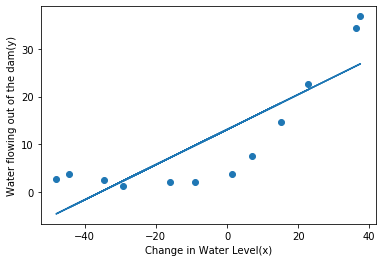

In [10]:
# Plot Linear Regression
plt.scatter(X,y)
plt.plot(X, np.hstack((np.ones((m,1)), X)) @ theta_opt)
plt.xlabel("Change in Water Level(x)")
plt.ylabel("Water flowing out of the dam(y)")

In [11]:
# Learning Curve
# Calculate Training Set Error and Validation Error
def LearningCurve(X,y, Xval, yval, lmbda):
    m = X.shape[0]
    n = X.shape[1]
    error_train = np.zeros((m,1))
    error_val = np.zeros((m,1))
    theta = np.zeros((n,1))
    for i in range(m):
        theta = opt.fmin_cg(maxiter = 50, f = LinearRegCostFunction, x0 = theta,fprime = gradf,
                        args = (X[:i+1,:],y[:i+1].flatten(),lmbda),disp=False)[:,np.newaxis]
        # Vary train error only bcos the model is trained on this
        error_train[i] = LinearRegCostFunction(theta,X[:i+1,:],y[:i+1],0)
        error_val[i] = LinearRegCostFunction(theta,Xval,yval,0)
    return error_train, error_val

In [12]:
lmbda = 0
mval = Xval.shape[0]
error_train, error_val = LearningCurve(np.hstack((np.ones((m,1)),X)), y, np.hstack((np.ones((mval,1)),Xval)), yval, lmbda,)
print(f"Training Error : {error_train}\n\n Validation Error {error_val}")
# Note : CV Error slowly decreases

Training Error : [[3.94430453e-31]
 [4.93038066e-31]
 [3.28659505e+00]
 [2.84267769e+00]
 [1.31540488e+01]
 [1.94439625e+01]
 [2.00985217e+01]
 [1.81728587e+01]
 [2.26094054e+01]
 [2.32614616e+01]
 [2.43172496e+01]
 [2.23739065e+01]]

 Validation Error [[205.12109575]
 [110.30036611]
 [ 45.01023138]
 [ 48.36890479]
 [ 35.8651657 ]
 [ 33.8299616 ]
 [ 31.9709858 ]
 [ 30.86244632]
 [ 31.13599796]
 [ 28.93620747]
 [ 29.55143162]
 [ 29.43381813]]


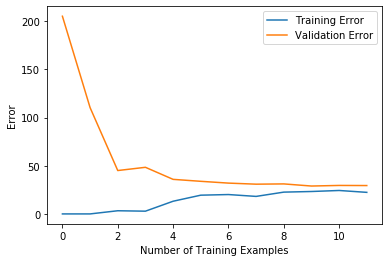

In [13]:
plt.plot(error_train,label = "Training Error")
plt.plot(error_val, label = "Validation Error")
plt.xlabel("Number of Training Examples")
plt.ylabel("Error")
plt.legend()
# High Bias - Underfitting(More Data will not help)

In [14]:
# Make Polynomial Features of 1D Vector
def PolyFeatures(X, p):
    X_poly = np.zeros((np.size(X),p))
    for i in range(p):
        X_poly[:,i] = (X ** (i+1)).flatten()
    return X_poly

In [15]:
def FeatureNormalize(X):
    # (value - mean)/std
    mu = np.mean(X, axis = 0)
    X_norm = X - mu
    
    # ddof paramater for dividing by N-1 instead of N
    sigma = np.std(X_norm, axis = 0, ddof=1)
    X_norm /= sigma
    return X_norm, mu, sigma

In [16]:
def PlotFit(min_x, max_x, mu,sigma,theta,p):
    # -1 dim numpy will figure out
    # Create new Xs to plot curve
    x = np.arange(min_x - 40, max_x + 40, 0.05).reshape(-1,1)
    # Translate and normalize given xs
    X_poly = PolyFeatures(x,p)
    X_poly -= mu
    X_poly /= sigma
    X_poly = np.hstack((np.ones((X_poly.shape[0],1)), X_poly))
    # plot x and calculated Y
    plt.plot(x, X_poly @ theta)

In [17]:
p = 8

X_poly = PolyFeatures(X, p)
X_poly, mu, sigma = FeatureNormalize(X_poly)
X_poly = np.hstack((np.ones((m,1)),X_poly))

X_poly_test = PolyFeatures(Xtest, p)
X_poly_test = X_poly_test - mu
X_poly_test /= sigma
X_poly_test = np.hstack((np.ones((Xtest.shape[0],1)),X_poly_test))

X_poly_val = PolyFeatures(Xval, p)
X_poly_val = X_poly_val - mu
X_poly_val /= sigma
X_poly_val = np.hstack((np.ones((Xval.shape[0],1)),X_poly_val))

In [18]:
# Learning Curve for Polynomial Regression
lmbda = 0.2
theta_opt = TrainLinearReg(X_poly,y,lmbda)

Text(0.5, 1.0, 'Polynomial Regression Fir (lambda=0.2)')

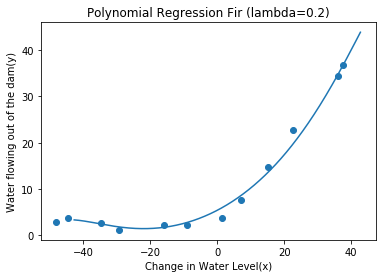

In [19]:
plt.scatter(X,y)
# Plot new Polynomial Curve
PlotFit(np.min(X_poly), np.max(X_poly), mu, sigma, theta_opt, p)
plt.xlabel("Change in Water Level(x)")
plt.ylabel("Water flowing out of the dam(y)")
plt.title(f"Polynomial Regression Fir (lambda={lmbda})")

In [20]:
# Calculate New Errors with Poly Features
error_train,error_val = LearningCurve(X_poly, y, X_poly_val,yval,lmbda)
print(f"Training Error\n{error_train}\nValidation Error\n{error_val}")

Training Error
[[8.87468518e-31]
 [7.43158125e-03]
 [1.58508498e-01]
 [8.82962025e-02]
 [7.07051785e-02]
 [8.08790982e-02]
 [4.07836059e-01]
 [4.02010644e-01]
 [6.28777665e-01]
 [5.68150916e-01]
 [5.20779139e-01]
 [6.99725620e-01]]
Validation Error
[[138.84677698]
 [143.37745712]
 [  9.28450083]
 [  9.89507226]
 [  9.93136107]
 [ 11.6044691 ]
 [  5.62835107]
 [  4.86790426]
 [  5.36032948]
 [  5.12059797]
 [  5.18046517]
 [  5.3860116 ]]


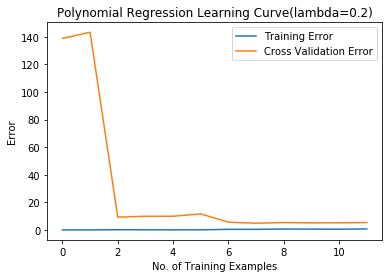

In [21]:
# Plot Learning Curve
plt.plot(error_train, label = "Training Error")
plt.plot(error_val, label = "Cross Validation Error")
plt.xlabel("No. of Training Examples")
plt.ylabel("Error")
plt.title(f"Polynomial Regression Learning Curve(lambda={lmbda})")
plt.legend()

In [22]:
# Validation for selecting lambda
def ValidationCurve(X_poly,y, X_poly_val, yval):
    lmbda = [0,0.001,0.003,0.01,0.03,0.1,0.3,1,3,10]
    error_train = np.zeros((len(lmbda),1))
    error_val = np.zeros((len(lmbda),1))
    for i in range(len(lmbda)):
        theta_opt = TrainLinearReg(X_poly,y,lmbda[i])
        # While training theta was already regularized with lambda
        error_train[i] = LinearRegCostFunction(theta_opt,X_poly,y,0)
        error_val[i] = LinearRegCostFunction(theta_opt,X_poly_val,yval,0)
    return error_train,error_val,lmbda

Text(0.5, 1.0, 'Validation Curve')

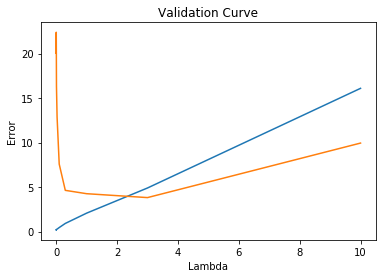

In [27]:
error_train, error_val, lmbda = ValidationCurve(X_poly,y, X_poly_val, yval)
plt.plot(lmbda,error_train,label="Training Error")
plt.plot(lmbda,error_val,label="Cross Validation Error")
plt.xlabel("Lambda")
plt.ylabel("Error")
plt.title("Validation Curve")